# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

import sys, os

sys.path.append(os.path.join(os.getcwd(), '../../..', 'leaspy'))

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory

In [2]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

In [3]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.1]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : x + amplitude * torch.cos(x * 2 * np.pi/periode)

In [4]:
n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 10.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

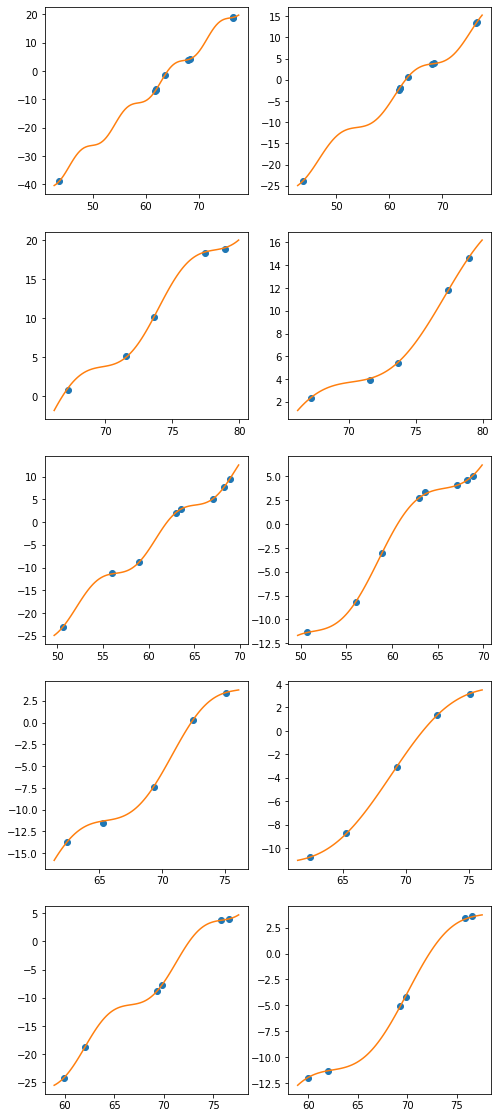

In [5]:
nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()

In [6]:
from leaspy.models.utils.OptimB import *

In [7]:
leaspy_data = Data.from_dataframe(data)

leaspy_test = Leaspy('linearB')

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional

leaspy_test.fit(leaspy_data, algorithm_settings=algo_settings)

settings = AlgorithmSettings('scipy_minimize', use_jacobian=True, loss="MSE")
results = leaspy_test.personalize(leaspy_data, settings)


The standard deviation of the noise at the end of the calibration is:
1.4219

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
1.2641

Personalization scipy_minimize took: 1s


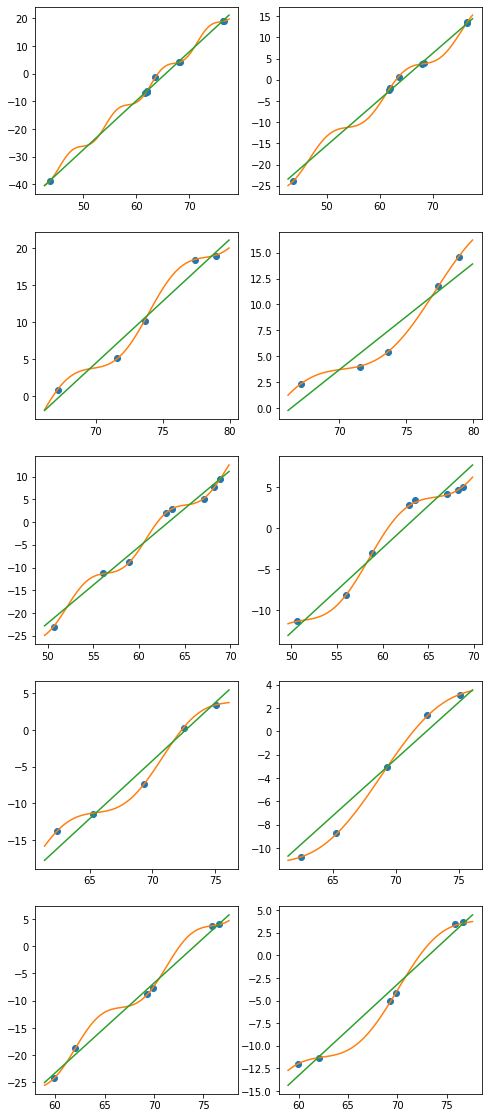

In [8]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))

def plot_fit(ax, results, model, individuals, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = results._individual_parameters[results._indices[i]]
        params["tpts"] = individuals[i]["tpts"]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
plt.show()

In [9]:
dataset = Dataset(leaspy_data)
_, ind_params = results.to_pytorch()
X = leaspy_test.model.compute_individual_tensorized_linear(dataset.timepoints, ind_params)

In [10]:
X.shape

torch.Size([100, 9, 2])

In [11]:
Y = dataset.values
print(Y.shape)
X = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
Y = Y.reshape((Y.shape[0] * Y.shape[1], Y.shape[2]))

torch.Size([100, 9, 2])


In [12]:
meta_settings = {"kernel_name" : "gaussian", "sigma":1.}
K = compute_kernel_matrix(X, meta_settings)

In [13]:
K.shape

torch.Size([900, 900])

In [14]:
import cvxpy as cp

W = cp.Variable((K.shape[0], leaspy_test.model.dimension))
K_ = cp.Parameter((K.shape[0], K.shape[0]), PSD=True)
K_.value = K.detach().numpy()
X_ = X.detach().numpy()
Y_ = Y.detach().numpy()

constraints = [cp.atoms.sum([cp.atoms.quad_form(W[:,k], K_) for k in range(leaspy_test.model.dimension)]) <= meta_settings["sigma"]**2/leaspy_test.model.dimension]
prob = cp.Problem(cp.Minimize(cp.atoms.norm(Y - (X + K_@W),"fro")), constraints)

ValueError: Parameter value must be positive semidefinite.

In [15]:
import scipy.linalg as LA

w, V = LA.eigh(K)
delta = np.abs(K - (V * w).dot(V.T))
LA.norm(delta, ord=2)

0.0003080572

So problem comes from the fact that the matrix is not PSD because we kept identical visits (the zeros).

The naive filtering is necessary :

In [16]:
X = leaspy_test.model.compute_individual_tensorized_linear(dataset.timepoints, ind_params)
Y = dataset.values

X_acc = []
Y_acc = []

for i in range(X.shape[0]):
    X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
    Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

X = torch.cat(X_acc)
Y = torch.cat(Y_acc)
print(X.shape, Y.shape)

torch.Size([600, 2]) torch.Size([600, 2])


In [17]:
meta_settings = {"kernel_name" : "gaussian", "sigma":1.}
K = compute_kernel_matrix(X, meta_settings)

In [18]:
W = cp.Variable((K.shape[0], leaspy_test.model.dimension))
K_ = cp.Parameter((K.shape[0], K.shape[0]), PSD=True)
K_.value = K.detach().numpy()
X_ = X.detach().numpy()
Y_ = Y.detach().numpy()

constraints = [cp.atoms.sum([cp.atoms.quad_form(W[:,k], K_) for k in range(leaspy_test.model.dimension)]) <= meta_settings["sigma"]**2/leaspy_test.model.dimension]
prob = cp.Problem(cp.Minimize(cp.atoms.norm(Y - (X + K_@W),"fro")), constraints)

ValueError: Parameter value must be positive semidefinite.

In [19]:
w, V = LA.eigh(K)
delta = np.abs(K - (V * w).dot(V.T))
LA.norm(delta, ord=2)

0.0009148665

So even here it is not enough. Let's just take sub-sampling to guarantee the matrix is not ill-conditioned :

In [20]:
indices = sub_sampling(X, 50)
X_control = X[indices]

In [21]:
meta_settings = {"kernel_name" : "gaussian", "sigma":5.}
K = compute_kernel_matrix(X, meta_settings, X_control)

In [22]:
K.shape

torch.Size([600, 50])

In [23]:
W = cp.Variable((K.shape[1], leaspy_test.model.dimension))
K_ = cp.Parameter((K.shape[1], K.shape[1]), PSD=True)
K_.value = K[indices].detach().numpy()
X_ = X.detach().numpy()
Y_ = Y.detach().numpy()

constraints = [cp.atoms.sum([cp.atoms.quad_form(W[:,k], K_) for k in range(leaspy_test.model.dimension)]) <= meta_settings["sigma"]**2/leaspy_test.model.dimension]
prob = cp.Problem(cp.Minimize(cp.atoms.norm(Y - (X + K.detach().numpy()@W),"fro")), constraints)

In [24]:
prob.solve(verbose=True)

print("Status: ", prob.status)
print("Optimal value: ", prob.value)
print("W: ", W.value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Apr 06 11:51:08 AM: Your problem has 100 variables, 1 constraints, and 2500 parameters.
(CVXPY) Apr 06 11:51:08 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 06 11:51:08 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 06 11:51:08 AM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 06 11:51:08 AM: Reduction chain: EvalParams -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 06 11:51:08 AM: Applying reduction EvalParams
(CVXPY) Apr 06 11:51:08 AM: Applying reduction Dcp

/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


 7  +2.764e+01  +2.771e+01  +3e-01  1e-04  6e-07  7e-02  7e-02  0.8297  2e-02   3  3  3 |  0  0
 8  +2.782e+01  +2.783e+01  +2e-02  8e-06  4e-08  5e-03  5e-03  0.9725  4e-02   3  3  3 |  0  0
 9  +2.784e+01  +2.784e+01  +6e-04  2e-07  1e-09  2e-04  2e-04  0.9688  1e-04   3  3  3 |  0  0
10  +2.784e+01  +2.784e+01  +7e-05  3e-08  1e-10  2e-05  2e-05  0.8954  1e-03   3  2  2 |  0  0
11  +2.784e+01  +2.784e+01  +3e-06  1e-09  5e-12  7e-07  6e-07  0.9764  2e-02   3  2  2 |  0  0
12  +2.784e+01  +2.784e+01  +1e-07  4e-10  3e-13  3e-08  3e-08  0.9547  6e-04   4  2  2 |  0  0

OPTIMAL (within feastol=3.8e-10, reltol=4.3e-09, abstol=1.2e-07).
Runtime: 0.140823 seconds.

-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Apr 06 11:51:09 AM: Problem status: optimal
(CVXPY) Apr 06 11:51:09 AM: Optimal v

In [25]:
W_opt = W.value
leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)

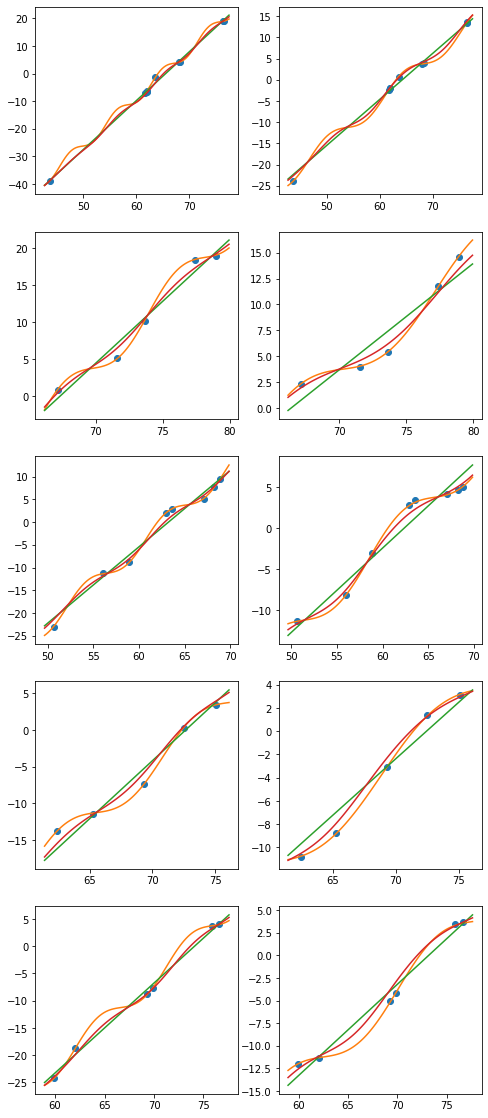

In [26]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
leaspy_test.model.B = lambda x: x 
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
plt.show()

In [44]:
def optim_solver(X, Y, K, indices, dim, sigma):
    W = cp.Variable((K.shape[1], dim))
    K_ = cp.Parameter((K.shape[1], K.shape[1]), PSD=True)
    K_.value = K[indices].detach().numpy()
    X_ = X.detach().numpy()
    Y_ = Y.detach().numpy()

    constraints = [cp.atoms.sum([cp.atoms.quad_form(W[:,k], K_) for k in range(dim)]) <= sigma**2/dim]
    prob = cp.Problem(cp.Minimize(cp.atoms.norm(Y - (X + K.detach().numpy()@W),"fro")), constraints)
    
    prob.solve()
    
    return W.value

def outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings, n_trials=100):
    
    fit_settings = meta_settings["fit"]
    leaspy_test.fit(leaspy_data, algorithm_settings=fit_settings)

    perso_settings = meta_settings["personalize"]
    results = leaspy_test.personalize(leaspy_data, perso_settings)
    _, ind_params = results.to_pytorch()
    
    X = leaspy_test.model.compute_individual_tensorized_linear(dataset.timepoints, ind_params)
    Y = dataset.values

    X_acc = []
    Y_acc = []

    for i in range(X.shape[0]):
        X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
        Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

    X = torch.cat(X_acc)
    Y = torch.cat(Y_acc)
    
    for k in range(n_trials):
        try:
    
            indices = sub_sampling(X, meta_settings["nb_control_points"])
            X_control = X[indices]

            K = compute_kernel_matrix(X, meta_settings, X_control)

            W_opt = optim_solver(X, Y, K, indices, leaspy_test.model.dimension, meta_settings["sigma"])
            break
        except:
            continue
    
    leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)
    return results


The standard deviation of the noise at the end of the calibration is:
1.4261

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
1.2651

Personalization scipy_minimize took: 13s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
0.8514

Calibration took: 3min 45s

The standard deviation of the noise at the end of the personalization is:
0.7431

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
0.8521

Calibration took: 3min 50s

The standard deviation of the noise at the end of the personalization is:
0.7446

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
0.8557

Calibration took: 3min 51s

The standard deviation of the noise at the end of the personalization is:
0.7424

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


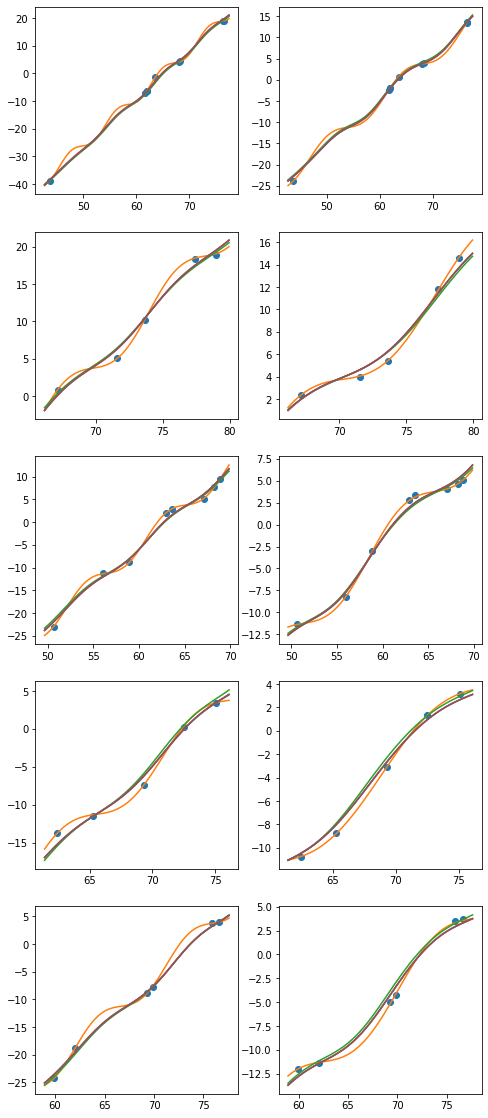

In [28]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5., 
                 "nb_control_points" : 50}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(4):
    results = outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
1.4309

Calibration took: 11s

The standard deviation of the noise at the end of the personalization is:
1.2733

Personalization scipy_minimize took: 10s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
1.0467

Calibration took: 1min 2s

The standard deviation of the noise at the end of the personalization is:
0.9214

Personalization scipy_minimize took: 17s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
1.0288

Calibration took: 59s

The standard deviation of the noise at the end of the personalization is:
0.9075

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


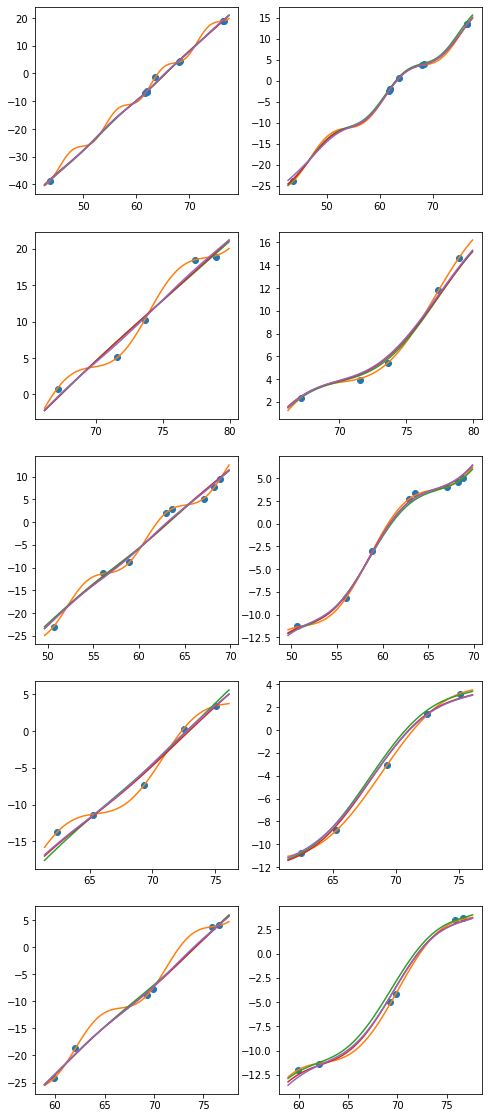

In [29]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 10., 
                 "nb_control_points" : 10}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(3):
    results = outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

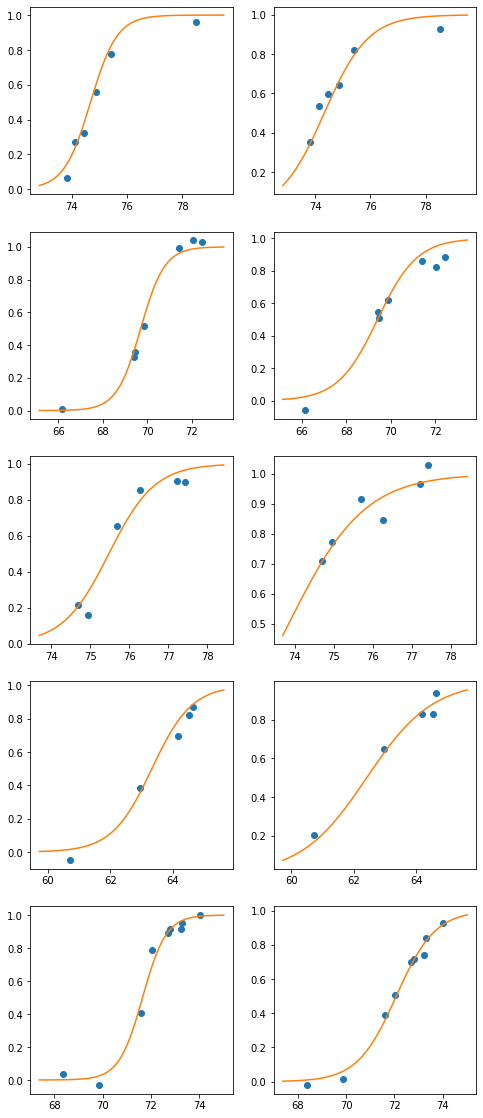

In [40]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.05]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

model1.B = lambda x : 1. / (1. + torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1158

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
0.1024

Personalization scipy_minimize took: 11s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
0.1122

Calibration took: 46s

The standard deviation of the noise at the end of the personalization is:
0.0996

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
0.1120

Calibration took: 46s

The standard deviation of the noise at the end of the personalization is:
0.0997

Personalization scipy_minimize took: 21s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


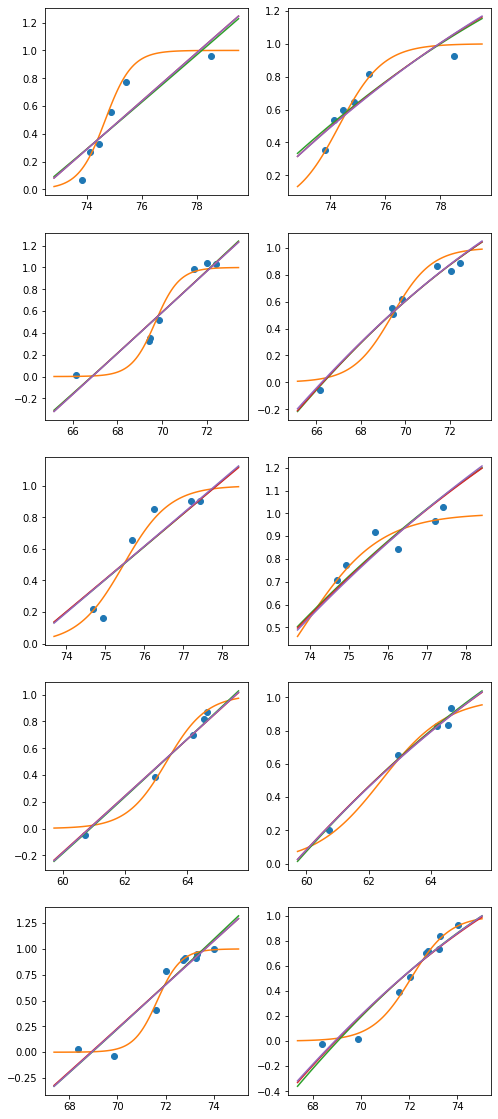

In [45]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5., 
                 "nb_control_points" : 10}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(3):
    results = outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()